## Feature Description

enrollee_id : Unique ID for candidate

city: City code

city_ development _index : Developement index of the city (scaled)

gender: Gender of candidate

relevent_experience: Relevant experience of candidate

enrolled_university: Type of University course enrolled if any

education_level: Education level of candidate

major_discipline :Education major discipline of candidate

experience: Candidate total experience in years

company_size: No of employees in current employer's company

company_type : Type of current employer

lastnewjob: Difference in years between previous job and current job

training_hours: training hours completed

target: 0 – Not looking for job change, 1 – Looking for a job change

In [776]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [777]:
path= r'C:\Satyaki\DATASETS\kaggle_hr_analytics'
os.chdir(path)
# Reading relevant data from the files
hr_train=pd.read_csv('aug_train.csv')
hr_test=pd.read_csv('aug_test.csv')
hr_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [778]:
print(f'Train_shape: {hr_train.shape}')
print(f'Test_shape:  {hr_test.shape}')

Train_shape: (19158, 14)
Test_shape:  (2129, 13)


## Data Cleaning

In [779]:
hr_train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [780]:
hr_train.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

#### Enrolee ID

In [781]:
hr_train['enrollee_id'].nunique()

19158

Enrollee ID has no useful information and can be dropped. I'll set it as index column

In [782]:
hr_train.set_index('enrollee_id',inplace=True)
hr_test.set_index('enrollee_id',inplace=True)

#### City

In [783]:
# hr_train['city']=hr_train['city'].apply(lambda x:x.split('_')[1])
# hr_test['city']=hr_test['city'].apply(lambda x:x.split('_')[1])

#### Gender

In [784]:
hr_train['gender'].value_counts(normalize=True)

Male      0.902457
Female    0.084505
Other     0.013038
Name: gender, dtype: float64

90% values in this column is Male. So all missing values will be assumed to be Male

In [785]:
hr_train['gender'].fillna('Male',inplace=True)
hr_test['gender'].fillna('Male',inplace=True)

#### Enrolled University

In [786]:
hr_train['enrolled_university'].value_counts(normalize=True)

no_enrollment       0.736043
Full time course    0.200139
Part time course    0.063818
Name: enrolled_university, dtype: float64

73% values in this column is no_enrollment. So missing values will be imputed with this value

In [787]:
hr_train['enrolled_university'].fillna('no_enrollment',inplace=True)
hr_test['enrolled_university'].fillna('no_enrollment',inplace=True)

#### Education level

In [788]:
hr_train['education_level'].value_counts(normalize=True)

Graduate          0.620280
Masters           0.233234
High School       0.107872
Phd               0.022141
Primary School    0.016472
Name: education_level, dtype: float64

here, the levels are more distributed, so missing values will be filled with nearest valid observation

In [789]:
hr_train['education_level'].fillna(method='ffill',inplace=True)
hr_test['education_level'].fillna(method='ffill',inplace=True)

#### Major Discipline

In [790]:
hr_train['major_discipline'].value_counts(normalize=True)

STEM               0.886632
Humanities         0.040930
Other              0.023310
Business Degree    0.020006
Arts               0.015479
No Major           0.013643
Name: major_discipline, dtype: float64

 88% values here are STEM. Same will be used for imputing missing values

In [791]:
hr_train['major_discipline'].fillna('STEM',inplace=True)
hr_test['major_discipline'].fillna('STEM',inplace=True)

#### experience

In [792]:
hr_train['experience'].value_counts(normalize=True)

>20    0.172105
5      0.074897
4      0.073482
3      0.070916
6      0.063688
2      0.059027
7      0.053842
10     0.051590
9      0.051328
8      0.042005
15     0.035929
11     0.034777
14     0.030692
1      0.028754
<1     0.027340
16     0.026607
12     0.025873
13     0.020898
17     0.017912
19     0.015922
18     0.014665
20     0.007752
Name: experience, dtype: float64

Observations are spread among different classes. Nearest value will be used to impute missing values

In [793]:
hr_train['experience'].fillna(method='ffill',inplace=True)
hr_test['experience'].fillna(method='ffill',inplace=True)

In [794]:
#### Company Size
hr_train['company_size'].value_counts(normalize=True)

50-99        0.233207
100-500      0.194478
10000+       0.152723
10/49        0.111271
1000-4999    0.100454
<10          0.098941
500-999      0.066339
5000-9999    0.042587
Name: company_size, dtype: float64

Nearest value will be used to fill missing observations

In [795]:
hr_train['company_size'].fillna(method='bfill',inplace=True)
hr_test['company_size'].fillna(method='bfill',inplace=True)

#### company_type

In [796]:
hr_train['company_type'].value_counts(normalize=True)

Pvt Ltd                0.754110
Funded Startup         0.076894
Public Sector          0.073360
Early Stage Startup    0.046320
NGO                    0.040022
Other                  0.009295
Name: company_type, dtype: float64

In [797]:
hr_train['company_type'].fillna('Pvt Ltd',inplace=True)
hr_test['company_type'].fillna('Pvt Ltd',inplace=True)

#### last new job

In [798]:
hr_train['last_new_job'].value_counts(normalize=True)

1        0.429143
>4       0.175607
2        0.154790
never    0.130878
4        0.054924
3        0.054657
Name: last_new_job, dtype: float64

In [799]:
hr_train['last_new_job'].fillna(method='ffill',inplace=True)
hr_test['last_new_job'].fillna(method='ffill',inplace=True)

In [800]:
hr_train.dropna(inplace=True)
hr_train.isnull().sum()

city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

## EDA

In [801]:
hr_train.describe(include='all')

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
count,19157,19157.000000,19157,19157,19157,19157,19157,19157,19157,19157,19157,19157.000000,19157.000000
unique,123,NaN,3,2,3,5,6,22,8,6,6,NaN,NaN
top,city_103,NaN,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1,NaN,NaN
freq,4355,NaN,17728,13792,14202,11890,17304,3294,4457,15956,8216,NaN,NaN
mean,NaN,0.828847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.363679,0.249361
std,NaN,0.123365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.058379,0.432654
min,NaN,0.448000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
25%,NaN,0.740000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,0.000000
50%,NaN,0.903000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.000000,0.000000
75%,NaN,0.920000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.000000,0.000000


In [802]:
## seggregating columns into numeric, ordinal and categorical types

num_cols=list(hr_train.select_dtypes(include=['int64','float64']).dtypes.index)
ord_cols=['experience','education_level','company_size','last_new_job']
cat_cols=[x for x in hr_train.columns if x not in num_cols and x not in ord_cols]
num_cols.remove('target')

<Figure size 1080x576 with 0 Axes>

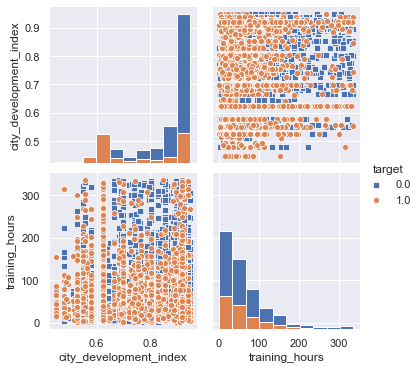

In [803]:
plt.figure(figsize=(15,8))
sns.pairplot(hr_train,hue='target',markers=['s','o'],diag_kind='hist')

In [804]:
# checking cardinality of the categorical columns
for col in cat_cols:
    print(f'{col}: {hr_train[col].nunique()}')

city: 123
gender: 3
relevent_experience: 2
enrolled_university: 3
major_discipline: 6
company_type: 6


<Figure size 720x576 with 0 Axes>

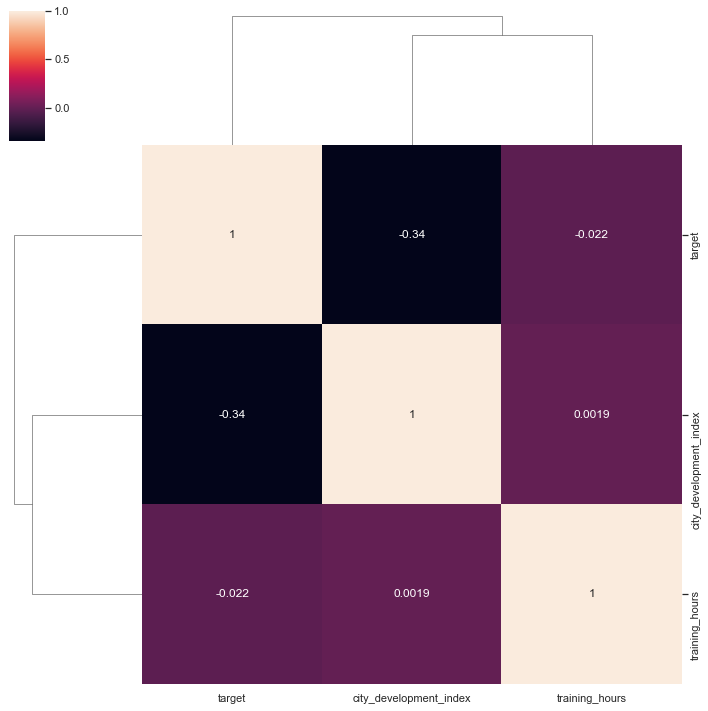

In [805]:
plt.figure(figsize=(10,8))
sns.clustermap(hr_train.corr(),annot = True)
plt.show()

So correlation between the target and numerical features is not very strong

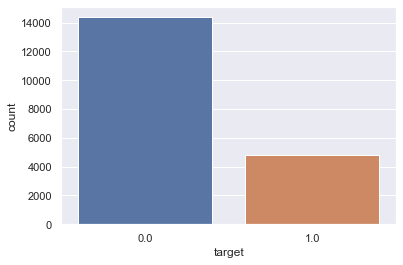

In [806]:
# checking distribution of the target column
sns.countplot(hr_train['target'])

In [807]:
def pie_chart(data,col):
    
    targets=list(data[col].value_counts().index)
    values=list(data[col].value_counts().values)
    
    fig=px.pie(values=values,names=targets,color_discrete_sequence=['darkcyan','lawngreen'],title=col)
    fig.show()

#### plotting categorical variables

In [ ]:
# for col in cat_cols:
#     pie_chart(hr_train,col)
# this produces the plots but they are not visible when exported to html

In [858]:
pie_chart(hr_train,'city')

In [860]:
pie_chart(hr_train,'gender')

In [863]:
pie_chart(hr_train,'relevent_experience')

In [864]:
pie_chart(hr_train,'enrolled_university')

In [865]:
pie_chart(hr_train,'major_discipline')

In [866]:
pie_chart(hr_train,'company_type')

#### plotting ordinal variables 

In [872]:
# for col in ord_cols:
#     pie_chart(hr_train,col)


In [868]:
pie_chart(hr_train,'experience')

In [869]:
pie_chart(hr_train,'education_level')

In [870]:
pie_chart(hr_train,'company_size')

In [871]:
pie_chart(hr_train,'last_new_job')

### Encoding

#### OneHot encoding

In [810]:
oh1=OneHotEncoder(handle_unknown='ignore')
train_cat=oh1.fit_transform(hr_train[cat_cols])
test_cat=oh1.transform(hr_test[cat_cols])
f_names=[j for i in oh1.categories_ for j in i]


#### Ordinal encoding

In [811]:
# Experience
ordinal_experience = {'<1':0, '1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, '10':10,
                      '11':11, '12':12, '13':13, '14':14, '15':15, '16':16, '17':17, '18':18, '19':19, '20':20, '>20':21}
hr_train['experience']=hr_train['experience'].map(ordinal_experience)
hr_test['experience']=hr_test['experience'].map(ordinal_experience)

In [812]:
# company size
ordinal_company_size = {'<10':0, '10/49':1, '50-99':2, '100-500':3, '500-999':4, '1000-4999':5, '5000-9999':6, '10000+':7}
hr_train['company_size']=hr_train['company_size'].map(ordinal_company_size)
hr_test['company_size']=hr_test['company_size'].map(ordinal_company_size)

In [813]:
##education level
ordinal_education_level = {'Primary School':0, 'High School':1, 'Graduate':2, 'Masters':3, 'Phd':4}
hr_train['education_level']=hr_train['education_level'].map(ordinal_education_level)
hr_test['education_level']=hr_test['education_level'].map(ordinal_education_level)

In [814]:
## last_new_job
ordinal_last_new_job = {'never':0, '1':1, '2':2, '3':3, '4':4, '>4':5}
hr_train['last_new_job']=hr_train['last_new_job'].map(ordinal_last_new_job)
hr_test['last_new_job']=hr_test['last_new_job'].map(ordinal_last_new_job)

In [815]:
ms=MinMaxScaler()
train_ord=ms.fit_transform(hr_train[ord_cols])
test_ord=ms.transform(hr_test[ord_cols])

#### Numeric variables

In [816]:
train_num=ms.fit_transform(hr_train[num_cols])
test_num=ms.transform(hr_test[num_cols])

In [817]:
#Joining the arrays 
feature_names=f_names+ord_cols+num_cols

X=np.concatenate([train_cat.toarray(),train_ord,train_num],axis=1)
y=hr_train['target']

features_test=np.concatenate([test_cat.toarray(),test_ord,test_num],axis=1)



#### Upsampling and train-test-split

In [818]:
sm=SMOTE(random_state=21)
X,y=sm.fit_resample(X,y)

In [819]:
#Train-test-split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.9,random_state=23)

### Model Building

In [820]:
# Baseline model
lr1=LogisticRegression()
lr1.fit(X_train,y_train)
pred=lr1.predict(X_test)
print(f1_score(y_test,pred))

0.6828534414308997


In [822]:
# Random Forest classifier
rf=RandomForestClassifier(random_state=23,n_jobs=3)

kf=KFold(n_splits=5,shuffle=True,random_state=23)
p_grid={'n_estimators':[300,600],
            'max_depth':[5,7,9],
            'max_features':[0.2,0.6],
            'min_samples_leaf':[5,7,11]
           }
rf_grid=RandomizedSearchCV(rf,param_distributions=p_grid,cv=kf)

In [823]:
%%time
rf_grid.fit(X_train,y_train)

Wall time: 1min 8s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=23, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=3, random_state=23),
                   param_distributions={'max_depth': [5, 7, 9],
                                        'max_features': [0.2, 0.6],
                                        'min_samples_leaf': [5, 7, 11],
                                        'n_estimators': [300, 600]})

In [824]:
rf_grid.best_params_

{'n_estimators': 600,
 'min_samples_leaf': 5,
 'max_features': 0.6,
 'max_depth': 9}

In [825]:
pred=rf_grid.predict(X_test)
f1_score(y_test,pred)

0.7433155080213903

In [730]:
## catboost
params = {
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [831]:
xgb = CatBoostClassifier(learning_rate=0.02, n_estimators=600, verbose = False)

In [832]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=42)


In [833]:
%%time
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   17.0s finished


Wall time: 19.3 s


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001B84A4C59C8>,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001B8529914C8>,
                   n_iter=5, n_jobs=4,
                   param_distributions={'max_depth': [3, 4, 5],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=3)

In [834]:
random_search.best_params_

{'subsample': 0.8, 'max_depth': 5}

In [835]:
model = CatBoostClassifier(learning_rate=0.02, n_estimators=600, verbose = False, subsample = 0.8, max_depth = 5)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(f1_score(y_test,y_pred))

0.8054495465550494


In [857]:
# Probabilities that a candidate will work for the company=probality of class 0
model.predict_proba(features_test)[:,0]

array([0.72372366, 0.69662229, 0.33242045, ..., 0.88180316, 0.85077195,
       0.86784136])

In [846]:
# Feature Importances
f_importances=pd.DataFrame()
f_importances['feature_names']=feature_names
f_importances['Coefficients']=model.feature_importances_
f_importances=f_importances.sort_values(by='Coefficients',ascending=True).set_index('feature_names')


Text(0.5, 0, 'Feature Importances')

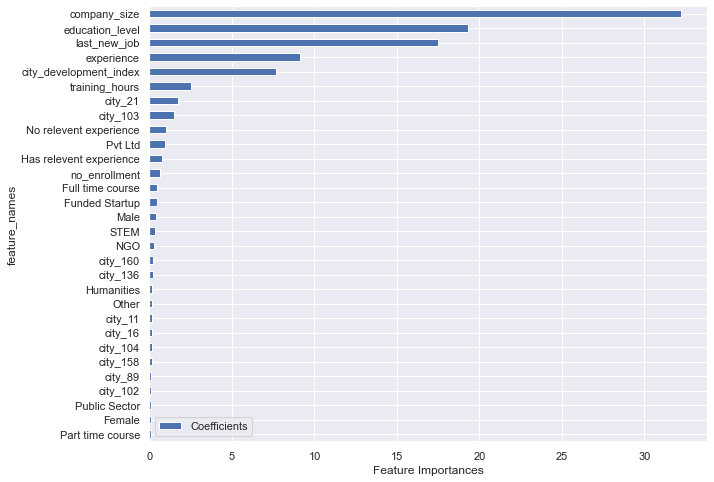

In [853]:
f_importances[f_importances['Coefficients']>=0.1].plot.barh(figsize=(10,8))
plt.xlabel('Feature Importances')
